<a href="https://colab.research.google.com/github/jmasonlee/efficiently_testing_etl_pipelines/blob/main/fixing_a_big_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## STEP 0.A: Setup Notebook

In [ ]:
!rm -rf efficiently_testing_etl_pipelines
!git clone https://github.com/jmasonlee/efficiently_testing_etl_pipelines.git
!cp -r /content/efficiently_testing_etl_pipelines/src/ .
!cp -r /content/efficiently_testing_etl_pipelines/tests/ .
!rm -rf efficiently_testing_etl_pipelines
!rm -rf tests/diamond_pricing_test*
!rm -rf tests/test_helpers/*verification_helpers.py
!rm -rf tests/conftest.py
!rm -rf sample_data


# STEP 0.B: Setup Tests

### Install Dependencies

For the exercise, we will need some special dependencies to allow us to run lots of tests in a notebook.

`ipytest` lets us run our tests in a notebook.



In [ ]:
!pip install ipytest

ipytest is what allows us to run our tests in a notebook. This next cell is not needed if you are writing tests in a separate pytest file.

In [ ]:
import ipytest
ipytest.autoconfig()

We are installing `pyspark` because it doesn't come with the base colab environment

In [ ]:
!pip install pyspark

In [ ]:
!pip install chispa

## Create a local SparkSession

Normally spark runs on a bunch of executors in the cloud. Since we want our tests to be able to run on a single dev machine, we make a fixture that gives us a local spark context.

In [ ]:
import pytest
from _pytest.fixtures import FixtureRequest
from pyspark import SparkConf
from pyspark.sql import SparkSession

@pytest.fixture(scope="session")
def spark(request: FixtureRequest):
    conf = (SparkConf()
        .setMaster("local")
        .setAppName("sample_pyspark_testing_starter"))

    spark = SparkSession \
        .builder \
        .config(conf=conf) \
        .getOrCreate()

    request.addfinalizer(lambda: spark.stop())
    return spark

## Create Helpers

This is a helper function that retrieves our test output from the expected.json file

In [ ]:
import json
from typing import List, Dict

from pyspark.pandas import DataFrame


def create_df_from_json(json_file, spark):
    return spark.read.option("multiline", "true").json(json_file)


def data_frame_to_json(df: DataFrame) -> List:
    output = [json.loads(item) for item in df.toJSON().collect()]
    output.sort(key=lambda item: item["id"])
    print(output)
    return output

def expected_json(name: str) -> Dict:
    with open(f"tests/fixtures/{name}") as f:
        return json.loads(f.read())

In [ ]:
import pyspark
def build_indep_vars(df, independent_vars, string_indexer, encoder, idx, vec, keep_intermediate=False, summarizer=True):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    idx = 'index'
    vec = 'vector'

    assembler = VectorAssembler(inputCols=independent_vars,
                                outputCol='indep_vars')
    pipeline  = Pipeline(stages=string_indexer+encoder+[assembler])
    model = pipeline.fit(df)
    df = model.transform(df)

    if not keep_intermediate:
        fcols = [c for c in df.columns if f'_{idx}' not in c[-3:] and f'_{vec}' not in c[-7:]]
        df = df[fcols]

    return df

def setup_categorical_vars(categorical_vars, idx, vec, independent_vars):
      from pyspark.ml.feature import StringIndexer, OneHotEncoder
      if categorical_vars:
        string_indexer = [StringIndexer(inputCol=x,
                                        outputCol=f"{x}_{idx}")
                          for x in categorical_vars]

        encoder        = [OneHotEncoder(dropLast=True,
                                        inputCol =f'{x}_{idx}',
                                        outputCol=f'{x}_{vec}')
                          for x in categorical_vars]

        new_independent_vars = ['{}_vector'.format(x) if x in categorical_vars else x for x in independent_vars]
      else:
        string_indexer, encoder = [], []
        new_independent_vars = independent_vars

      return string_indexer, encoder, new_independent_vars

def check_input(categorical_vars, df, independent_vars):
    assert (type(
        df) is pyspark.sql.dataframe.DataFrame), 'pypark_glm: A pySpark dataframe is required as the first argument.'
    assert (type(
        independent_vars) is list), 'pyspark_glm: List of independent variable column names must be the third argument.'
    for iv in independent_vars:
        assert (type(iv) is str), 'pyspark_glm: Independent variables must be column name strings.'
        assert (iv in df.columns), 'pyspark_glm: Independent variable name is not a dataframe column.'
    if categorical_vars:
        for cv in categorical_vars:
            assert (type(cv) is str), 'pyspark_glm: Categorical variables must be column name strings.'
            assert (cv in df.columns), 'pyspark_glm: Categorical variable name is not a dataframe column.'
            assert (cv in independent_vars), 'pyspark_glm: Categorical variables must be independent variables.'


In [ ]:
from pyspark.sql import DataFrame, Window, Column
from pyspark.sql.functions import log, when, mean, col

def replace_null(orig: Column, average: Column):
    return when(orig.isNull(), average).otherwise(orig)

############################ THE CODE WE ARE TESTING ###########################
def transform(df: DataFrame) -> DataFrame:

    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
    return df
################################################################################


# STEP 1: Investigate The Test

## STEP 1A - Run The Test

- [ ] Run the test.
  * Hover your mouse over the number in the square brackets on the upper left side of the cell.
  * It should turn into a play button.
- [ ] Click the play button. The test will start to run.
  * When the run finishes, the test should pass. You can see the results at the bottom of your cell.
  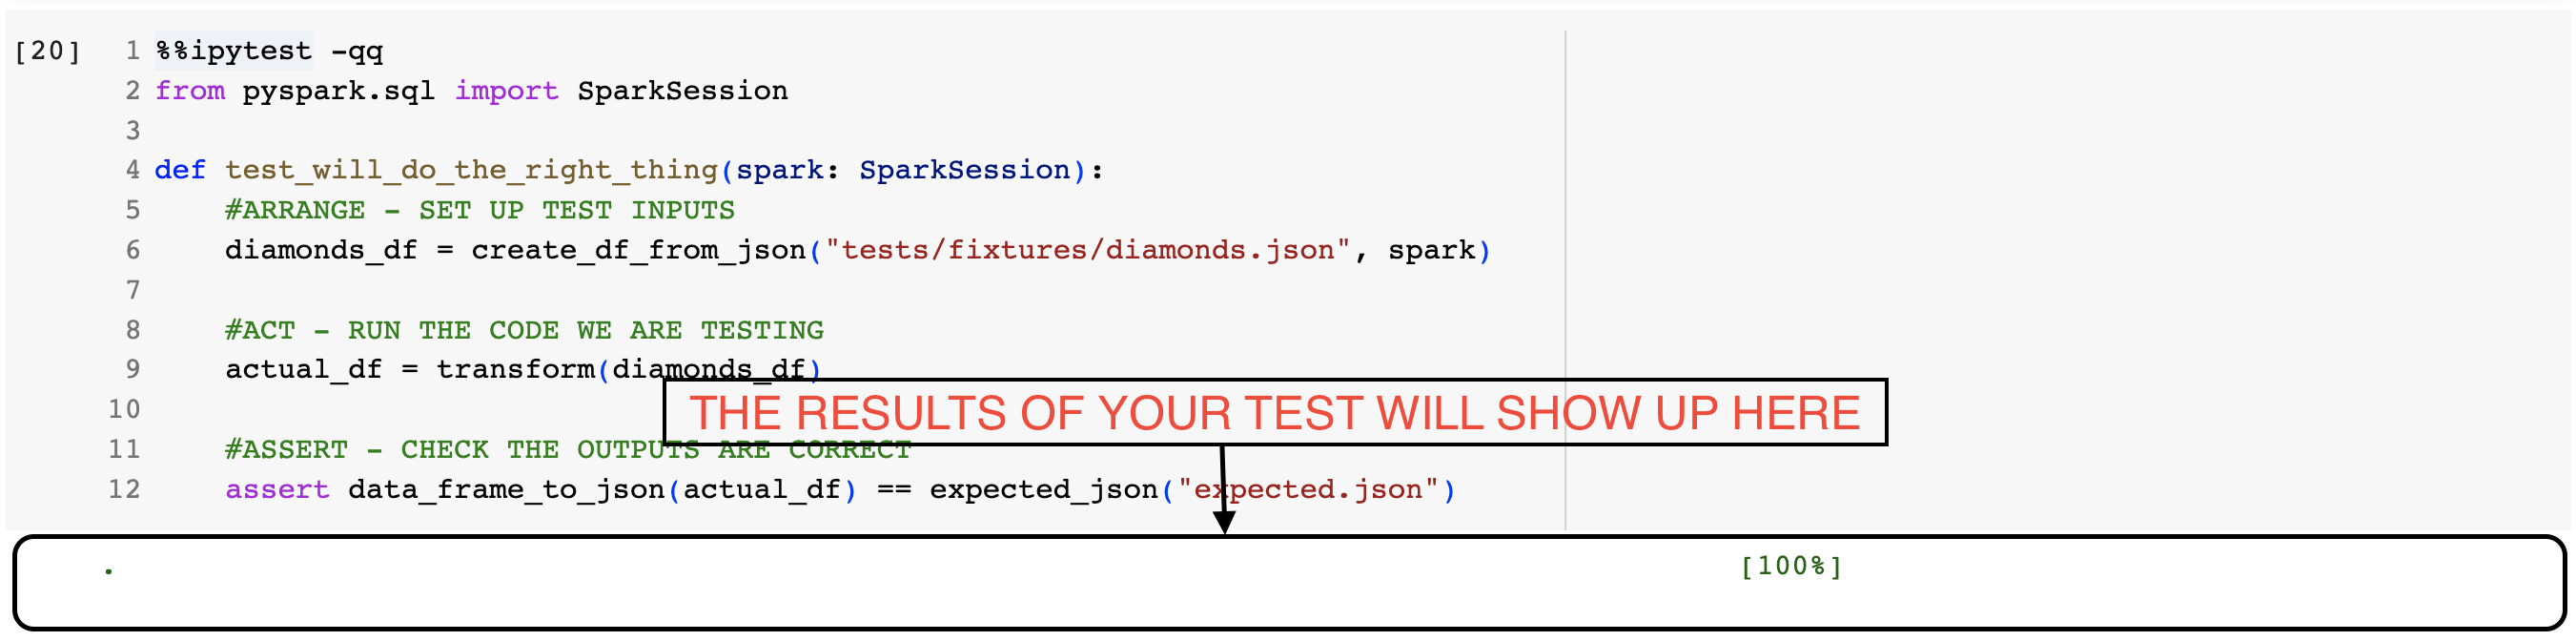

**How long did the first run of your test take?**

In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession


def test_will_do_the_right_thing(spark: SparkSession):
    #ARRANGE - SET UP TEST INPUTS
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    #ACT - RUN THE CODE WE ARE TESTING
    actual_df = transform(df)

    #ASSERT - CHECK THE OUTPUTS ARE CORRECT
    assert data_frame_to_json(actual_df) == expected_json("expected.json")


## STEP 1B - Investigate the inputs
The `ARRANGE` part of the test sets up the inputs. In this case, it is reading in a json file, and converting that file to a dataframe called `df`.

Let's take a look at it!

- [ ] Add `assert False` to the end of your test so that we can see outputs
- [ ] Immediately after we create df, let's print out the whole dataframe, by adding:
```
df.show()
```
- [ ] Run your test.

The test will fail because we used `assert False`.
You will see an image of the dataframe printed out after this line:
```
--------------------------------------- Captured stdout call ---------------------------------------
```


In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession


def test_will_do_the_right_thing(spark: SparkSession):
    #ARRANGE - SET UP TEST INPUTS
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)
    # df.show() # <-UNCOMMENT THIS LINE

    #ACT - RUN THE CODE WE ARE TESTING
    actual_df = transform(df)

    #ASSERT - CHECK THE OUTPUTS ARE CORRECT
    assert data_frame_to_json(actual_df) == expected_json("expected.json")
    # assert False # <-UNCOMMENT THIS LINE

## STEP 1C - Investigate the outputs
The assert block checks that our code produces the output we expect when we provide it with a predictable input.

We expect the output of our test to match what's in the `expected.json` file.

- [ ] Let's find the file.
  * Expand the tests directory
  * Expand the fixtures directory
- [ ] Let's open the file.
  * Double-click on `expected.json`.
  
  
  **What is the price of the DI-26-null-price diamond in expected.json?**



In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession


def test_will_do_the_right_thing(spark: SparkSession):
    #ARRANGE - SET UP TEST INPUTS
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    #ACT - RUN THE CODE WE ARE TESTING
    actual_df = transform(df)

    #ASSERT - CHECK THE OUTPUTS ARE CORRECT
    assert data_frame_to_json(actual_df) == expected_json("expected.json")

# Step 2: Setup For the Saff Squeeze

Let's get ready to improve the test.

**our bug**: Diamonds of the same cut and clarity are influencing the calculated price of diamonds with a different color. Only diamonds with the same cut, clarity _**and color**_ should be influencing the calculated price for diamonds with a null price.

## STEP 2A - Test for the desired behaviour
- [ ] There is a second json file (`expected_correct.json`) where the expected price for the unpriced diamond has been updated to the correct value. Use that file name as the argument passed to `expected_json`
- [ ] Run the test. It should fail.
- [ ] Look at the left margin of your test. Find the red $\color{red}{\text{E}}$'s.
They mark the specific reason your test failed.

**How many E's are there?**

In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession


def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    ########### Rename the "expected.json" file below to "expected_correct.json"
    assert data_frame_to_json(actual_df) == expected_json("expected.json")

## STEP 2B - Duplicate the test

- [ ] Duplicate the test. Now you should have two copies of the same test.
  * One copy will stay the same, so we can make sure that nothing is broken.
  * The second copy is what we will change in the next steps.
- [ ] Name the second test
```
test_null_price_is_replaced_based_on_cut_clarity_and_color
```
- [ ] Run the tests. They should both fail.
- [ ] Look at the first line of your test run output. Find the capital $\color{red}{\text{F}}$'s. Those indicate failing tests.

**How many F's do you see?**

In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession


# Duplicate the test below and rename the duplicate to:
# test_null_price_is_replaced_based_on_cut_clarity_and_color

########################## START OF THE ORIGINAL TEST ##########################
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")
########################### END OF THE ORIGINAL TEST ###########################

##STEP 2C - Temporarily disable the original test
- [ ] Mark the failing test with `@pytest.mark.skip()` to make our output less confusing.
- [ ] Run the tests. You should see this in your cell output:
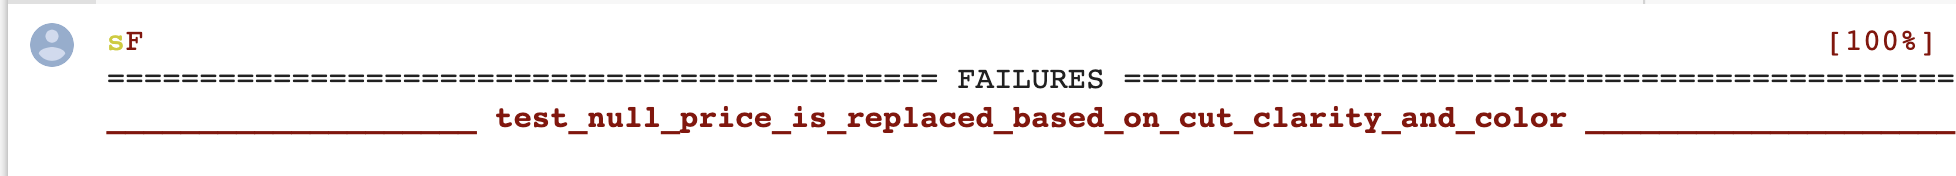

The lowercase $\color{goldenrod}{\text{s}}$$\color{red}{\text{F}}$
indicates that two tests were run. One test ($\color{goldenrod}{\text{s}}$) was skipped. The other test ($\color{red}{\text{F}}$) failed.

Immediately below the FAILURES line, you should see the name of the test that failed, in red. It is the test we are changing:
$\color{red}{\text{____________________ test_null_price_is_replaced_based_on_cut_clarity_and_color ____________________}}$




In [ ]:
%%ipytest -qq
# import pytest # <- UNCOMMENT THIS LINE

from pyspark.sql import SparkSession


# @pytest.mark.skip() # <- UNCOMMENT THIS LINE
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

# Step 3: Make The Assert Specific

Right now, our test compares everything in the output dataframe to everything in a large json file. That's a lot of rows to compare and we can't tell which ones are important!

Let's make this test assert on the thing we actually care about - the output price of the diamond!

##STEP 3A - Show the actual dataframe and remove the old assert

We have added `actual_df.show()` and `assert False` to the bottom of the test we want to change, so that we can see how the dataframe changes over the next few steps.

- [ ] Uncomment them and run the test to see what the dataframe looks like initially.
- [ ] Find the red $\color{red}{\text{E}}$'s.
  * **What is the error message next to them?**
- [ ] Delete the old assert.
- [ ] Run the test. It should fail.
- [ ] Find the red $\color{red}{\text{E}}$'s.
  * **What is the error message next to them now?**

In [ ]:
%%ipytest -qq
import pytest

from pyspark.sql import SparkSession


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    ########################### DELETE THE LINE BELOW ##########################
    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")
    # actual_df.show() # <- Uncomment this line
    # assert False # <- Uncomment this line

## STEP 3B - Filter the dataframe down to one row.

- [ ] Filter the dataframe for the unique id of the diamond we care about:  
`DI-26-null-price`
- [ ] Run the test. It should fail. You should see a DataFrame with only one row printed out below

```
--------------------------------------- Captured stdout call ---------------------------------------
```


In [ ]:
%%ipytest -qq
import pytest

from pyspark.sql import SparkSession


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)
    actual_df=actual_df.filter(actual_df.id == "PUT THE DIAMOND ID HERE")

    actual_df.show()
    assert False

## STEP 3C - Add expected values



- [ ] Create a new column in our dataframe that contains our expected price:  
`actual_df=actual_df.withColumn('expected_price', lit(3333.0))`
- [ ] Run the test. It should fail. You should see a new column added to your dataframe called `expected_price`, with a single row containing the value 3333.0


In [ ]:
%%ipytest -qq
import pytest

from pyspark.sql import SparkSession
from pyspark.sql.functions import lit


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")

    ###################### Replace the_expected_column with expected_price
    ###################### Replace 0 with the expected price.
    actual_df=actual_df.withColumn('the_expected_column', lit(0))

    actual_df.show()
    assert False

## STEP 3D - Assert the expected value equals the actual values

- [ ] Add this imports to the top of the cell, below the `%%ipytest -qq` line:  
`from chispa import assert_column_equality`  
- [ ] Assert the value in the price column matches the value we want:  
`assert_column_equality(actual_df, 'price', 'expected_price')`
- [ ] Run your test. It will fail. Look for the $\color{red}{\text{E}}$'s. The error should look like this:

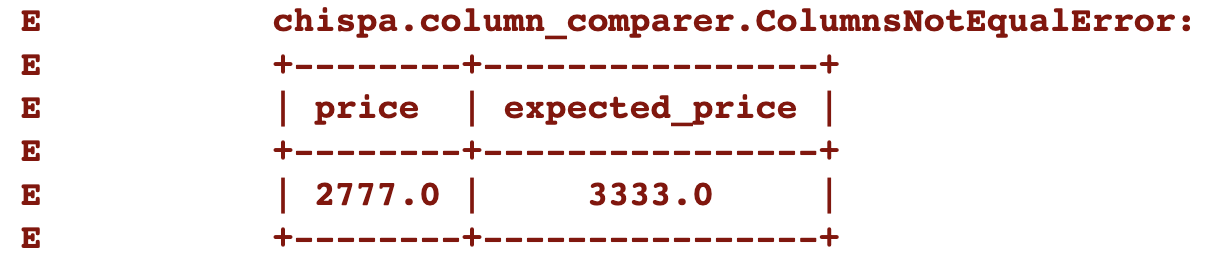

In [ ]:
%%ipytest -qq
from chispa import assert_column_equality

import pytest

from pyspark.sql import SparkSession
from pyspark.sql.functions import lit


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))

    #### IN THE LINE BELOW, REPLACE 'the_actual_column' WITH 'price'.
    #### IN THE LINE BELOW, REPLACE 'the_expected_column' WITH 'expected_price'.
    assert_column_equality(actual_df, 'the_actual_column', 'the_expected_column')

    actual_df.show()
    assert False

## STEP 3E - What's wrong with our test?

- [ ] Make a typo in your id, so no rows are picked by our filter
- [ ] Comment out the assert False
- [ ] Run your tests. They Pass? 🙀
- [ ] Uncomment your assert False. Run your tests. You should be able to see the results of .show().

**`assert_column_equality` compares the values in two columns to see if they are identical. Why is our test passing?**




In [ ]:
%%ipytest -qq
import pytest

from pyspark.sql import SparkSession


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price") # <- MAKE A TYPO HERE
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

    actual_df.show()
    assert False # <-COMMENT THIS OUT FOR YOUR TESTS TO PASS. UNCOMMENT IT TO SEE THE OUTPUT FROM ACTUAL_DF.SHOW()

## STEP 3F - Check we have exactly one row

There is a risk that our dataframe is empty, so we want to make sure it isn't.

- [ ] After you filter, add:
```
assert actual_df.count() == 1
```
- [ ] Run your tests. They should fail exactly the same way they did before.


In [ ]:
%%ipytest -qq
import pytest

from pyspark.sql import SparkSession


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    # assert actual_df.count() == 1 # <- Uncomment this line
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

    actual_df.show()
    assert False

## STEP 3F - Make the assert logic easier to work with

Let's extract a function so the assert is easier to work with.

- [ ] Copy the lines in between the comments and paste them into the body of the `assert_diamond_has_expected_price` function.
- [ ] Delete the lines you copied, and replace them with a single method call:
```
assert_diamond_has_expected_price()
```
- [ ] Run your test, it should fail with the chispa error:
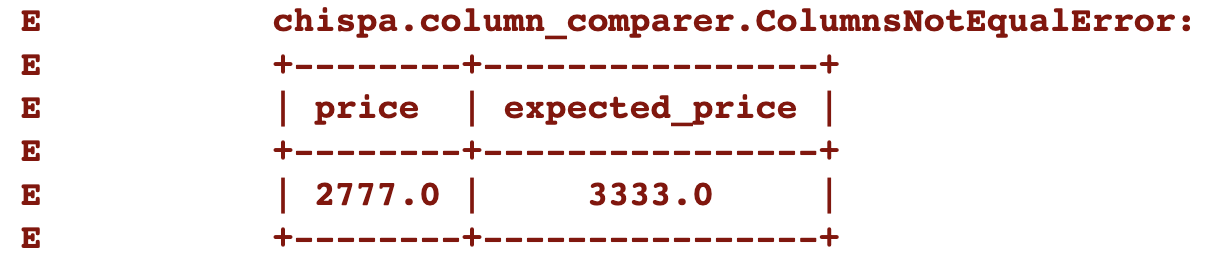

In [ ]:
%%ipytest -qq
from chispa import assert_column_equality

import pytest

from pyspark.sql import SparkSession
from pyspark.sql.functions import lit


def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    pass # <- REPLACE THIS LINE WITH THE COPIED LINES


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    ######################## COPY THESE LINES ####################
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')
    ##############################################################
    # Replace the 4 lines above with a single call to the method:
    # assert_diamond_has_expected_price(actual_df)

    actual_df.show()
    assert False

## STEP 3G - Clean up

- [ ] Delete `assert False` from the bottom of your test.
- [ ] Delete `actual_df.show()` from the bottom of your test.
- [ ] Run your test, it should fail with the chispa error:
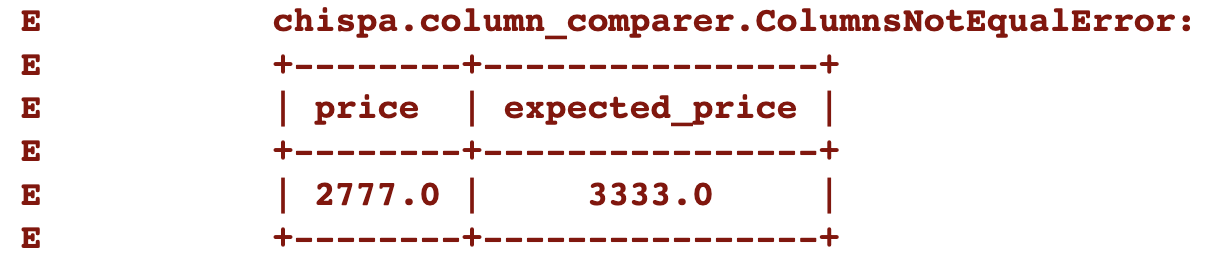

In [ ]:
%%ipytest -qq
from chispa import assert_column_equality

import pytest

from pyspark.sql.functions import lit


def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert_diamond_has_expected_price(actual_df)

    actual_df.show() # <- DELETE THIS LINE
    assert False # <- DELETE THIS LINE

# Step 4: Reduce Duplicate Coverage by Squeezing the bottom

Right now, our test is running the entire transform function. Because there are multiple tests in `diamonds.json`, each test is running the same large block of code over and over again.

## STEP 4A - Put the transform function where you can work with it

- [ ] Run the test. It should be failing with this error.
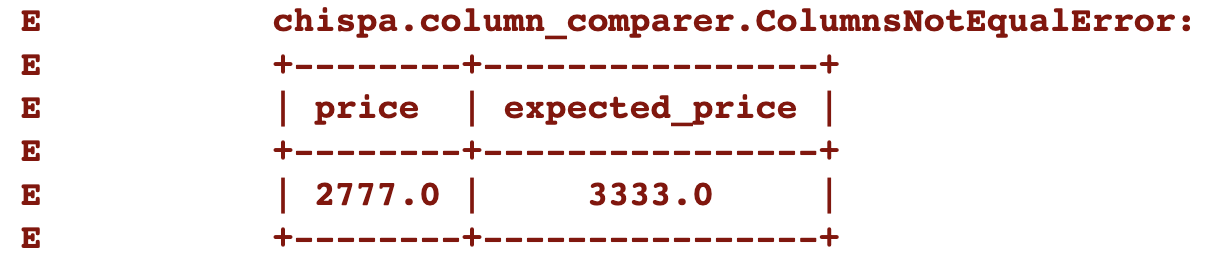
- [ ] Uncomment the line that maps `df` to `actual_df`
- [ ] Copy the body of the tranform function into the test in between the two lines of comments
- [ ] Delete the line that calls the transform function.
- [ ] Run the test. It should still be failing with the same error.


In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

############################ THE CODE WE ARE TESTING ###########################
def transform(df: DataFrame) -> DataFrame:

### THE BODY OF THE TRANSFORM FUNCTION STARTS HERE
    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
### THE BODY OF THE TRANSFORM FUNCTION ENDS HERE
    return df
################################################################################



def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    ###################### PASTE THE BODY OF THE TRANSFORM HERE ################
    ############################################################################
    # actual_df = df  # <- UNCOMMENT THIS LINE
    actual_df = transform(df)# <-- DELETE THIS LINE.
    assert_diamond_has_expected_price(actual_df)


## STEP 4B - Squeeze the bottom

**Squeeze the bottom until you find the bug**
- [ ] Move your assert up one line at a time.  
- [ ] After each move, run your test.  
- [ ] If it fails for a different reason, figure out why it's failing.
- [ ] If the test fails for the same reason, the line wasn't important for the bug you wanted to catch. Delete it.
- [ ] Continue until your failure reason changes.

If your error doesn't look _**exactly**_ like this one, it's time to STOP 🛑

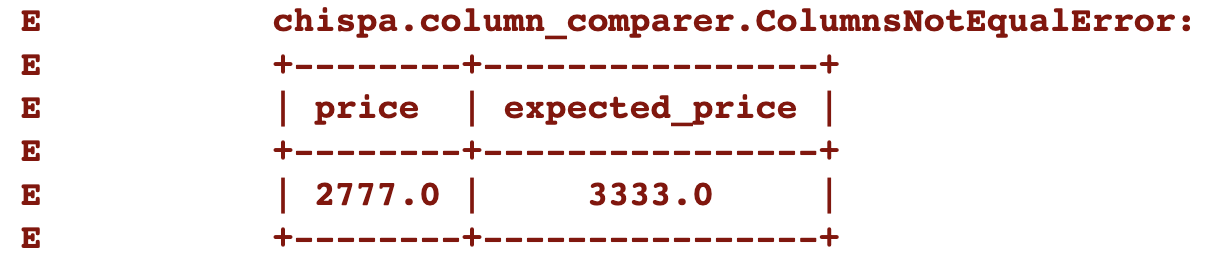

**Where does the failure reason change? When do you need to stop?**

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality


############################ THE CODE WE ARE TESTING ###########################
def transform(df: DataFrame) -> DataFrame:
    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
    return df
################################################################################



def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    actual_df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)

    assert_diamond_has_expected_price(actual_df)

# Step 5: Simplify the Top

## STEP 5A - Create the minimum inputs needed to reproduce the bug
- [ ] Delete the line that reads in from diamonds.json
- [ ] Replace it with two lines, one that parses the json text file to a string, and the other that converts the json string to spark
- [ ] Run your test. It should fail with the `ColumnsNotEqualError`.

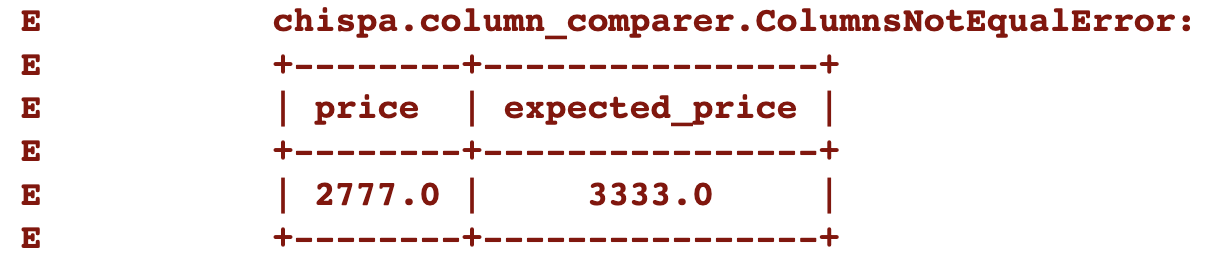


In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

############################ THE CODE WE ARE TESTING ###########################
def transform(df: DataFrame) -> DataFrame:
    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
    return df
################################################################################


def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    ############################# DELETE THE LINE BELOW ########################
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)
    #json_text = Path("./tests/fixtures/diamonds.json").read_text() # <- UNCOMMENT THIS LINE
    #df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text])) # <- UNCOMMENT THIS LINE

    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    assert_diamond_has_expected_price(df)






## STEP 5B - Create the minimum Inputs needed to reproduce the bug
- [ ] Copy the contents of `tests/fixtures/diamonds.json` to a multiline string.
- [ ] Delete the line that reads the input data from a file
- [ ] Run your test. It should fail with the `ColumnsNotEqualError`.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

############################ THE CODE WE ARE TESTING ###########################
def transform(df: DataFrame) -> DataFrame:
    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
    return df
################################################################################


def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
      PASTE CONTENTS OF tests/fixtures/diamonds.json HERE
    '''
    ############################# DELETE THE LINE BELOW ########################
    json_text = Path("./tests/fixtures/diamonds.json").read_text()
    df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    assert_diamond_has_expected_price(df)






## STEP 5C - Squeeze the inputs
- [ ] Run your test. It should fail with the `ColumnsNotEqualError`.
- [ ] Delete the objects from the JSON array one at a time.
- [ ] After each deletion, run your test. If it fails with a different error, undo the delete.
- [ ] Move onto the next object
- [ ] At the end, you should have the minimum objects needed for our test to test the behaviour
- [ ] Run your test. It should fail with the `ColumnsNotEqualError`.

This is the error you're looking for:
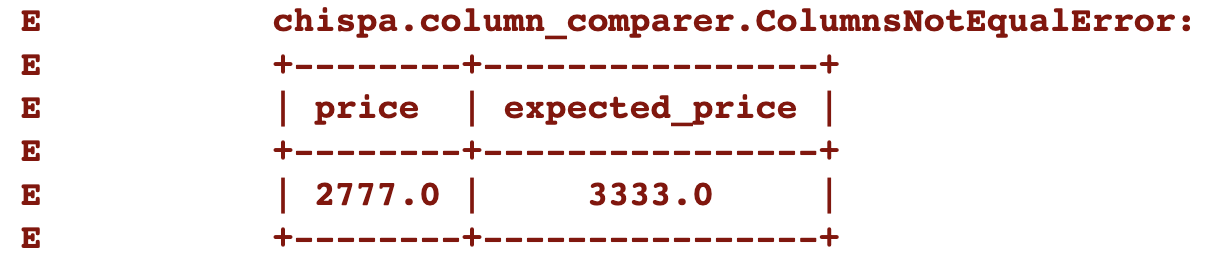

**How many inputs are the minimum number of inputs you need?**

**VERY IMPORTANT:** Your test will fail for the wrong reasons if the JSON array ends in a comma.

Make sure the last 4 lines of the array always look like this:
```
    "z": null
  }
]
    '''
 ```

NOT this:
```
    "z": null
  },
]
    '''
```

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

############################ THE CODE WE ARE TESTING ###########################
def transform(df: DataFrame) -> DataFrame:
    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
    return df
################################################################################


def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
      [
  {
    "id": 1,
    "carat": 0.23,
    "cut": "Ideal",
    "color": "E",
    "clarity": "SI2",
    "depth": 61.5,
    "table": 55,
    "price": 326,
    "x": 3.95,
    "y": 3.98,
    "z": 2.43
  },
  {
    "id": "minimum_inputs",
    "carat": 0.23,
    "cut": "Good",
    "color": "F",
    "clarity": "SI1",
    "depth": null,
    "table": null,
    "price": null,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-26-null-price",
    "carat": 0.21,
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": null,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-26",
    "carat": 0.21,
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": 3332,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-26",
    "carat": 0.21,
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": 3334,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-27",
    "carat": 0.21,
    "cut": "Very Good",
    "color": "D",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": 2692,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-30",
    "carat": 0.32,
    "cut": "Good",
    "color": "D",
    "clarity": "I1",
    "depth": 60.9,
    "table": 58,
    "price": 345,
    "x": 4.38,
    "y": 4.42,
    "z": 2.68
  },
  {
    "id": "DI-28",
    "carat": 0.21,
    "cut": "Good",
    "color": "G",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": 1665,
    "x": null,
    "y": null,
    "z": null
  }
]

    '''

    df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    assert_diamond_has_expected_price(df)






## Step 5D - Squeeze the inputs
- [ ] Run your test. It should fail with the `ColumnsNotEqualError`.
- [ ] Delete the properties from each JSON object one at a time.
- [ ] After each deletion, run your test. If it fails with any error that is not the `ColumnsNotEqualError`, undo the delete.
- [ ] Move onto the next property
- [ ] At the end, you should have the minimum objects and properties needed for our test to test the behaviour
- [ ] Run your test. It should fail with the same `ColumnsNotEqualError`.

This is the error you're looking for:
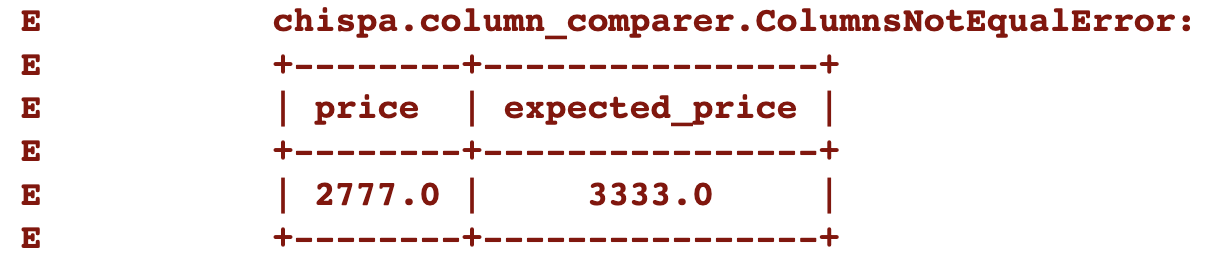

**At the end, Which properties are you left with?**

**VERY IMPORTANT:** Your test will fail for the wrong reasons if the last property in any JSON object ends in a comma.

Make sure the last property of each object always looks like this:
```
    "z": null
  }
 ```

NOT this:
```
    "z": null,
  }
```

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

############################ THE CODE WE ARE TESTING ###########################
def transform(df: DataFrame) -> DataFrame:
    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
    return df
################################################################################



def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
      [
  {
    "id": "DI-26-null-price",
    "carat": 0.21,
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": null,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-26",
    "carat": 0.21,
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": 3332,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-26",
    "carat": 0.21,
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": 3334,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-28",
    "carat": 0.21,
    "cut": "Good",
    "color": "G",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": 1665,
    "x": null,
    "y": null,
    "z": null
  }
]

    '''

    df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    assert_diamond_has_expected_price(df)






## STEP 5E - Squeeze the top

- [ ] Run your test. It should fail with the `ColumnsNotEqualError`.
- [ ] Comment out:

```
actual_df = df.withColumn('lprice', log('price'))
```
- [ ] Run your test. It fails with the `ColumnsNotEqualError`.
- [ ] This means that line isn't important to the behaviour we are testing. Delete it.


In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

############################ THE CODE WE ARE TESTING ###########################
def transform(df: DataFrame) -> DataFrame:
    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
    return df
################################################################################



def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
      [
  {
    "id": "DI-26-null-price",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": null
  },
  {
    "id": "DI-26",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": 3332
  },
  {
    "id": "DI-26",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": 3334
  },
  {
    "id": "DI-28",
    "cut": "Good",
    "color": "G",
    "clarity": "VVS1",
    "price": 1665
  }
]

    '''

    df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    df = df.withColumn('lprice', log('price')) # <- Comment out this line. Run your tests and check the error. If it is the right error, delete this line.
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    assert_diamond_has_expected_price(df)






## STEP 5F - Fix the bug

- [ ] Run your test. It should fail with the `ColumnsNotEqualError`
- [ ] Try commenting out the next line from the top.
- [ ] Run your test. It should fail for a different reason. This means that line is important for the behaviour you are testing.
- [ ] Read the line. Can you find the bug?
- [ ] Add 'color' to the list of args passes into the window function.
- [ ] Run your test. It should pass.


In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

############################ THE CODE WE ARE TESTING ###########################
def transform(df: DataFrame) -> DataFrame:
    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
    return df
################################################################################


def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
      [
  {
    "id": "DI-26-null-price",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": null
  },
  {
    "id": "DI-26",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": 3332
  },
  {
    "id": "DI-26",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": 3334
  },
  {
    "id": "DI-28",
    "cut": "Good",
    "color": "G",
    "clarity": "VVS1",
    "price": 1665
  }
]

    '''

    df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    assert_diamond_has_expected_price(df)






## STEP 5G - Clean up - extract a method

The four lines in the test work together to give us the behaviour we care about. Let's extract them into a method.
- [ ] Run the test. It should pass.
- [ ] Copy the four lines into the body of the `calculate_avg_price_for_similar_diamonds` method.
- [ ] Delete them from your test and call that method instead.
- [ ] Run the test. It should pass.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

############################ THE CODE WE ARE TESTING ###########################
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    #PASTE THE LINES YOU COPIED FROM BELOW
    return df


def transform(df: DataFrame) -> DataFrame:
    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
    return df
################################################################################

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
      [
  {
    "id": "DI-26-null-price",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": null
  },
  {
    "id": "DI-26",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": 3332
  },
  {
    "id": "DI-26",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": 3334
  },
  {
    "id": "DI-28",
    "cut": "Good",
    "color": "G",
    "clarity": "VVS1",
    "price": 1665
  }
]

    '''

    df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    ############################## CUT THESE LINES #############################
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    ############################################################################
    # df = calculate_avg_price_for_similar_diamonds(df) # <- UNCOMMENT THIS LINE

    assert_diamond_has_expected_price(df)






## STEP 5H - Use the new method.

- [ ] Run your test. It should pass.
- [ ] Replace the same lines in the actual code with a call to the new method.
- [ ] Run your test. It should pass.


In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

############################ THE CODE WE ARE TESTING ###########################
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))

    return df

def transform(df: DataFrame) -> DataFrame:
    df = df.withColumn('lprice', log('price'))
    ############################ DELETE THESE LINES ############################
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    ############################################################################
    # df = calculate_avg_price_for_similar_diamonds(df) # <- UNCOMMENT THIS LINE

    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
    return df
################################################################################


def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
      [
  {
    "id": "DI-26-null-price",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": null
  },
  {
    "id": "DI-26",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": 3332
  },
  {
    "id": "DI-26",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": 3334
  },
  {
    "id": "DI-28",
    "cut": "Good",
    "color": "G",
    "clarity": "VVS1",
    "price": 1665
  }
]

    '''

    df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    df = calculate_avg_price_for_similar_diamonds(df)

    assert_diamond_has_expected_price(df)






## STEP 5I - Run all the tests.

- [ ] Run your test. It should pass. The old test should still be skipped
- [ ] Delete `pytest.mark.skip()` from the top of the old test.
- [ ] Run your tests. Both should pass.


In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

############################ THE CODE WE ARE TESTING ###########################
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))

    return df

def transform(df: DataFrame) -> DataFrame:
    df = df.withColumn('lprice', log('price'))
    df = calculate_avg_price_for_similar_diamonds(df)

    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
    return df
################################################################################


def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')


@pytest.mark.skip() # <- DELETE THIS LINE
def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
      [
  {
    "id": "DI-26-null-price",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": null
  },
  {
    "id": "DI-26",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": 3332
  },
  {
    "id": "DI-26",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": 3334
  },
  {
    "id": "DI-28",
    "cut": "Good",
    "color": "G",
    "clarity": "VVS1",
    "price": 1665
  }
]

    '''

    df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    df = calculate_avg_price_for_similar_diamonds(df)

    assert_diamond_has_expected_price(df)






# Step 6: Work with clean tests!

## STEP 6A - Make tests correct for new behaviour

Having only two other diamonds with the same cut, clarity and color is not enough to accurately predict the price of a third based on mean alone. We have a new requirement - we should only make that prediction if we have 3 matching diamonds or more. Otherwise we should drop the row

Let's update our test case to be correct for the new behaviour.

- [ ] Run your tests, they should pass.
- [ ] Add 3 more matching diamonds with a price to the dataframe.
- [ ] Run your tests. They should pass.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit
from chispa import assert_column_equality
from typing import Dict

############################ THE CODE WE ARE TESTING ###########################
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))

    return df

def transform(df: DataFrame) -> DataFrame:
    df = df.withColumn('lprice', log('price'))
    df = calculate_avg_price_for_similar_diamonds(df)

    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
    return df
################################################################################

def unpriced_diamond() -> Dict:
  return {"id": "DI-26-null-price", "cut": "Good", "color": "D", "clarity": "VVS1", "price": None}

def diamond_with_price(price: float, different: Dict={}) -> Dict:
  diamond = unpriced_diamond()
  diamond["id"] = "with-price"
  diamond["price"] = price

  if different:
    for key in different.keys():
      diamond["id"] = f"{diamond['id']}-wrong-{key}"

  return diamond | different


def assert_unpriced_diamond_has_expected_price(actual_df: DataFrame, price: float) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(price))
    assert_column_equality(actual_df, 'price', 'expected_price')


def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)
    actual_df.show()

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    df = spark.createDataFrame([
      unpriced_diamond(),

      diamond_with_price(price=3333.0),
      diamond_with_price(price=3333.0),
      # <- Add 1 more diamond with a price here

      diamond_with_price(price=1665.0, different={"color": "G"}),
      diamond_with_price(price=1665.0, different={"clarity": "S1"}),
      diamond_with_price(price=1665.0, different={"cut": "Very Good"})
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(df)

    assert_unpriced_diamond_has_expected_price(actual_df, price=3333.0)

## STEP 6B - Test for the new behaviour.

We need to check that a diamond with no price, and less than 5 matching diamonds gets dropped from the dataframe.

We haven't written the code yet, so the test will fail once it's written.

- [ ] Run your tests. Two will pass, one will be skipped.
- [ ] Remove the line to skip the test.
- [ ] Construct the input dataset inside of the spark.createDataFrame function. (Use the helper methods!)
- [ ] Select the 5 columns we care about
- [ ] Construct the expected dataset using the helper methods
- [ ] Uncomment the assertion at the end. In this case, we are looking for a whole row that is _missing_ so we will use `assert_df_equality` from chispa.
- [ ] Run your tests. They will fail with a new error: $\color{red}{\text{chispa.dataframe_comparer.DataFramesNotEqualError}}$

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit
from chispa import assert_column_equality, assert_df_equality
from typing import Dict

############################ THE CODE WE ARE TESTING ###########################
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))

    return df

def transform(df: DataFrame) -> DataFrame:
    df = df.withColumn('lprice', log('price'))
    df = calculate_avg_price_for_similar_diamonds(df)

    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
    return df
################################################################################


def assert_unpriced_diamond_has_expected_price(actual_df: DataFrame, price: float) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(price))
    assert_column_equality(actual_df, 'price', 'expected_price')


def unpriced_diamond() -> Dict:
  return {"id": "DI-26-null-price", "cut": "Good", "color": "D", "clarity": "VVS1", "price": None}

def diamond_with_price(price: float, different: Dict={}) -> Dict:
  diamond = unpriced_diamond()
  diamond["id"] = "with-price"
  diamond["price"] = price

  if different:
    for key in different.keys():
      diamond["id"] = f"{diamond['id']}-wrong-{key}"

  return diamond | different


def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)
    actual_df.show()

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    df = spark.createDataFrame([
      unpriced_diamond(),

      diamond_with_price(price=3333.0),
      diamond_with_price(price=3333.0),
      diamond_with_price(price=3333.0),

      diamond_with_price(price=1665.0, different={"color": "G"}),
      diamond_with_price(price=1665.0, different={"clarity": "S1"}),
      diamond_with_price(price=1665.0, different={"cut": "Very Good"})
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(df)

    assert_unpriced_diamond_has_expected_price(actual_df, price=3333.0)

@pytest.mark.skip() # <- DELETE THIS LINE
def test_null_price_is_dropped_with_too_few_examples(spark: SparkSession):
    df = spark.createDataFrame([
      unpriced_diamond(),

      # <- Add 2 diamonds with a price of 3333.0 here

      # We don't need these diamonds. Remove them
      diamond_with_price(price=1665.0, different={"color": "G"}),
      diamond_with_price(price=1665.0, different={"clarity": "S1"}),
      diamond_with_price(price=1665.0, different={"cut": "Very Good"})
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(df).select(
        # WE ONLY CARE ABOUT 5 COLUMNS FOR THIS TEST. SELECT ['id', 'color', 'clarity', 'cut', 'price']
    )

    expected_df = spark.createDataFrame([
        #OUR OUTPUT SHOULD BE TWO DIAMONDS WITH A PRICE OF 3333.0
    ])

    #UNCOMMENT THE ASSERTION
    # assert_df_equality( actual_df, expected_df, ignore_column_order=True, ignore_row_order=True )

## STEP 6C - See all your tests pass with the new behaviour added

We have added a function with the new behaviour.

- [ ] Uncomment `drop_null_rows_with_too_few_examples` and it's invocation.
- [ ] Run your tests. They should pass.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, count
from chispa import assert_column_equality, assert_df_equality
from typing import Dict

############################ THE CODE WE ARE TESTING ###########################

############################ UNCOMMENT THE LINES BELOW #########################
# def drop_null_rows_with_too_few_examples(df: DataFrame) -> DataFrame:
#   counts_of_cut_clarity_color_groups_df = df.groupby(
#       'cut', 'clarity', 'color').agg(count('*').alias('num_matches'))
#   df = df.join(counts_of_cut_clarity_color_groups_df, on=['cut','clarity', 'color'])
#   df.show()
#   df = df.filter((df.price.isNotNull()) | (3 < df.num_matches))
#   return df

def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    # df = drop_null_rows_with_too_few_examples(df) # <- Uncomment this line
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))

    return df

def transform(df: DataFrame) -> DataFrame:
    df = df.withColumn('lprice', log('price'))
    df = calculate_avg_price_for_similar_diamonds(df)

    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    check_input(['clarity', 'color'], df, ['carat', 'clarity', 'color'])
    indexer, encoder, independent_vars = setup_categorical_vars(
        ['clarity', 'color'], 'index', 'vector', ['carat', 'clarity', 'color']
    )
    df = build_indep_vars(df, independent_vars, indexer, encoder, "index", "vector",
                                      keep_intermediate=False,
                                      summarizer=True)
    return df
################################################################################

def unpriced_diamond() -> Dict:
  return {"id": "DI-26-null-price", "cut": "Good", "color": "D", "clarity": "VVS1", "price": None}

def diamond_with_price(price: float, different: Dict={}) -> Dict:
  diamond = unpriced_diamond()
  diamond["id"] = "with-price"
  diamond["price"] = price

  if different:
    for key in different.keys():
      diamond["id"] = f"{diamond['id']}-wrong-{key}"

  return diamond | different

def assert_unpriced_diamond_has_expected_price(actual_df: DataFrame, price: float) -> None:
    actual_df=actual_df.filter(actual_df.id == "DI-26-null-price")
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(price))
    assert_column_equality(actual_df, 'price', 'expected_price')


def test_will_do_the_right_thing(spark: SparkSession):
    df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(df)
    actual_df.show()

    assert data_frame_to_json(actual_df) == expected_json("expected_correct_with_filter.json")


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    df = spark.createDataFrame([
      unpriced_diamond(),

      diamond_with_price(price=3333.0),
      diamond_with_price(price=3333.0),
      diamond_with_price(price=3333.0),

      diamond_with_price(price=1665.0, different={"color": "G"}),
      diamond_with_price(price=1665.0, different={"clarity": "S1"}),
      diamond_with_price(price=1665.0, different={"cut": "Very Good"})
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(df)

    assert_unpriced_diamond_has_expected_price(actual_df, price=3333.0)


def test_null_price_is_dropped_with_too_few_examples(spark: SparkSession):
    df = spark.createDataFrame([
      unpriced_diamond(),
      diamond_with_price(price=3333.0),
      diamond_with_price(price=3333.0)
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(df).select(
        ['id', 'color', 'clarity', 'cut', 'price']
    )

    expected_df = spark.createDataFrame([
        diamond_with_price(price=3333.0),
        diamond_with_price(price=3333.0)
    ])

    assert_df_equality(actual_df, expected_df, ignore_column_order=True, ignore_row_order=False)

# Extras

### Instructions - Specific Assert with Pandas
- [ ] import pandas:  
`import pandas as pd`
- [ ] Filter the dataframe for the unique id of the diamond we care about:  
  `actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')`
- [ ] Create your expected dataframe using Pandas:  
 `expected = pd.DataFrame(({'id': ["DI-26-null-price"], 'price':[3333.0] }))`
- [ ] Select the column you care about:  
  `actual_df=actual_df.select(['id', 'price'])
- [ ] Assert for dataframe equality using pandas:  
  `pd.testing.assert_frame_equal(actual_df, expected)`

### Instructions - Specific Assert with JSON properties

- [ ] Filter the dataframe for the unique id of the diamond we care about:  
  `actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')`
- [ ] Convert your dataframe to JSON:  
`actual_df_json = data_frame_to_json(actual_df)`
- [ ] Assert the price property of the first object matches your expected price:  
`assert actual_df_json[0]['price'] == 3333.0`